# Detection model

-toc:true

## Import Module

In [ ]:
from google.colab import drive
drive.mount('/content/drive') # 내 드라이브에 있는 데이터를 읽을 때 사용(코랩에 구글 드라이브를 연결시켜주는 코드)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np 
import pandas as pd

# Deeplearning
import torch
import torchvision
from fastai.vision.all import *
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim
import matplotlib.pyplot as plt
from PIL import Image

# Data load
import os
import cv2
import glob
import random
from torch.utils.data import TensorDataset, Dataset # 텐서데이터셋
from torch.utils.data import DataLoader # 데이터로더
from torchvision import datasets, transforms

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


## 데이터 확인

In [ ]:
df_meta=pd.read_csv("/content/drive/MyDrive/data/Chest_xray_Corona_Metadata.csv",index_col=0)
df_meta.head()

,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
0,IM-0128-0001.jpeg,Normal,TRAIN,NaN,NaN
1,IM-0127-0001.jpeg,Normal,TRAIN,NaN,NaN
2,IM-0125-0001.jpeg,Normal,TRAIN,NaN,NaN
3,IM-0122-0001.jpeg,Normal,TRAIN,NaN,NaN
4,IM-0119-0001.jpeg,Normal,TRAIN,NaN,NaN


In [ ]:
len(df_meta)

5910

In [ ]:
df_meta['Dataset_type'].value_counts() #train 5286

TRAIN    5286
TEST      624
Name: Dataset_type, dtype: int64

In [ ]:
df_meta[df_meta['Dataset_type']=='TRAIN']['Label'].value_counts()

Pnemonia    3944
Normal      1342
Name: Label, dtype: int64

In [ ]:
unique_labels_1 = []
for i in  df_meta['Dataset_type']:
    if i not in unique_labels_1:
        unique_labels_1.append(i)
        
print(unique_labels_1)

['TRAIN', 'TEST']


In [ ]:
unique_labels = []
for i in  df_meta['Label']:
    if i not in unique_labels:
        unique_labels.append(i)
        
print(unique_labels)

['Normal', 'Pnemonia']


In [ ]:
data=pd.read_csv("/content/drive/MyDrive/data/Chest_xray_Corona_Metadata.csv",index_col=0)
len(data)

5910

In [ ]:
data.iloc[5219:5223,:]

,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
5219,streptococcus-pneumoniae-pneumonia-temporal-evolution-1-day0.jpg,Pnemonia,TRAIN,Streptococcus,bacteria
5220,streptococcus-pneumoniae-pneumonia-1.jpg,Pnemonia,TRAIN,Streptococcus,bacteria
5221,kjr-21-e25-g001-l-a.jpg,Pnemonia,TRAIN,COVID-19,Virus
5225,kjr-21-e24-g003-l-a.jpg,Pnemonia,TRAIN,COVID-19,Virus


- train test 폴더 만들기
```python
data=pd.read_csv("/content/drive/MyDrive/data/Chest_xray_Corona_Metadata.csv")
Path_test="/content/drive/MyDrive/data/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test/"
Total_images=len(os.listdir(Path_test))
normal=0
infected =0
name=data['X_ray_image_name']
label=data['Label']
image_type=data['Dataset_type']
all_dir=os.listdir(Path_test)
os.mkdir("test")
os.mkdir("test/Infected")
os.mkdir("test/Normal")
wrong=0
for i in range(len(image_type)):
    if image_type[i]=='TEST':
        if name[i] in all_dir:
            if label[i]=='Normal':
                normal=normal+1
                shutil.copy(Path_test+'/'+name[i],'test/Normal/'+name[i])
            else:
                infected=infected+1
                shutil.copy(Path_test+'/'+name[i],'test/Infected//'+name[i])
        else:
            wrong=wrong+1
!zip -r /content/test_data.zip /content/test            
```

데이터의 클래스가 'Normal', 'Pnemonia'임을 알 수 있음 

----------

### 데이터 분포 확인

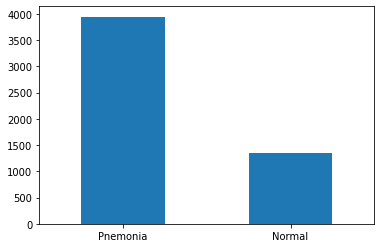

In [ ]:
df_meta[df_meta["Dataset_type"]=="TRAIN"]["Label"].value_counts()
df_meta[df_meta["Dataset_type"]=="TRAIN"]["Label"].value_counts().plot.bar(rot=0)

클래스의 분포가 위와 같음을 알 수 있음

AxesSubplot(0.125,0.125;0.775x0.755)


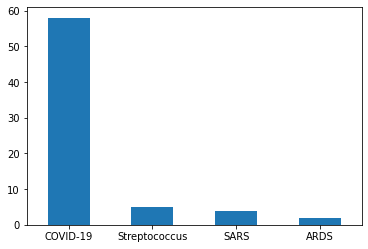

In [ ]:
df_pne = df_meta[df_meta["Label"]=='Pnemonia']

print(df_pne["Label_2_Virus_category"].value_counts().plot.bar(rot=0))

AxesSubplot(0.125,0.125;0.775x0.755)


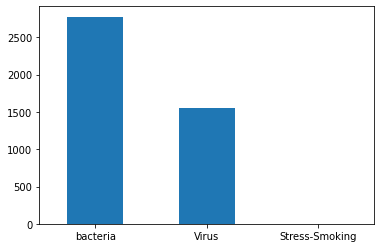

In [ ]:
print(df_pne["Label_1_Virus_category"].value_counts().plot.bar(rot=0))

### 클래스별 이미지 확인하기

In [ ]:
path = '/content/drive/MyDrive/data/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/'

정상 이미지 출력

normal
이미지 크기:  (1013, 1528, 3)


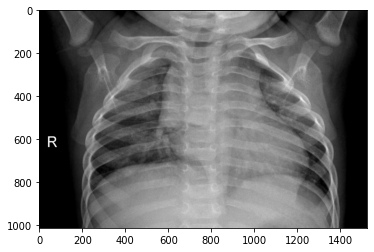

In [ ]:
normal = df_meta[df_meta["Label"]=="Normal"]
image = cv2.imread(path + normal.iloc[0]['X_ray_image_name'])
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB) 
plt.imshow(image)
print('normal')
print('이미지 크기: ',image.shape)

--------------------
폐렴(Pnemonia(corona)) 이미지 출력

pnemonia
이미지 크기:  (1752, 1736, 3)


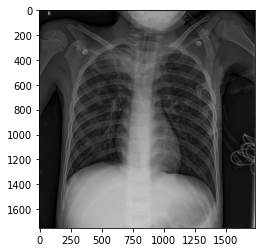

In [ ]:
pnemonia=df_meta[df_meta["Label"]=="Pnemonia"]
image = cv2.imread(path +pnemonia.iloc[0]['X_ray_image_name'])
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
plt.imshow(image)
print('pnemonia')
print('이미지 크기: ',image.shape)

-----------------------
### 이미지 파일 확인

In [ ]:
images=glob.glob("/content/drive/MyDrive/data/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/*")
images=pd.Series(images)
print("train 이미지 파일 개수: ",len(images))

train 이미지 파일 개수:  5309


In [ ]:
image_jpg=glob.glob("./content/drive/MyDrive/data/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/*.jpg")
image_jpg=pd.Series(image_jpg)
print("jpg 파일 개수: ",len(image_jpg),'\n')

image_jpeg=glob.glob("/content/drive/MyDrive/data/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/*.jpeg")
image_jpeg=pd.Series(image_jpeg)
print("jpeg 파일 개수: ",len(image_jpeg),'\n')

image_png=glob.glob("/content/drive/MyDrive/data/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/*.png")
image_png=pd.Series(image_png)
print("png 파일 개수: ", len(image_png))

jpg 파일 개수:  0 

jpeg 파일 개수:  5264 

png 파일 개수:  8


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


In [ ]:
# image파일의 종류는 png와 jpeg, jpg인 것을 확인
len(images)==len(image_png)+len(image_jpeg)+len(image_jpg)

False

> 데이터를 확인해보니 이미지는 3개의 형식(jpg, jpeg, png)으로 저장되어있고 이미지들은 모두 다른 shape를 갖고 있었다.  
이는 데이터 전처리과정에서 이미지의 크기를 모두 통일시키는 방향으로 문제를 해결해야 할 것 같다.  
또한 label1과 2를 사용해 데이터를 분류해보았을때 코로나 환자의 이미지는 총 train data의 1%밖에 안되는 것을 확인할 수 있었다.  
그래서 우리는 폐렴을 detect하는 model을 만드는 것으로 프로젝트 방향을 바꾸기로 하였다.

## 데이터 전처리
---
당장은 아래와 같은 코드를 만들었지만 [링크](https://greeksharifa.github.io/pytorch/2018/11/10/pytorch-usage-03-How-to-Use-PyTorch/)를 읽어보고 다시 코드를 만들어 볼 것!

### TYPE1)

In [ ]:
class BasicBlock(nn.Module):
    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()

        # 3x3 필터를 사용 (너비와 높이를 줄일 때는 stride 값 조절)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes) # 배치 정규화(batch normalization)

        # 3x3 필터를 사용 (패딩을 1만큼 주기 때문에 너비와 높이가 동일)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes) # 배치 정규화(batch normalization)

        self.shortcut = nn.Sequential() # identity인 경우
        if stride != 1: # stride가 1이 아니라면, Identity mapping이 아닌 경우
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x) # (핵심) skip connection
        out = F.relu(out)
        return out

In [ ]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        # 64개의 3x3 필터(filter)를 사용
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes # 다음 레이어를 위해 채널 수 변경
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

# ResNet18 함수 정의
def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


In [ ]:
ResNet18

<function __main__.ResNet18()>

#### transforms

`>` Resize를 통해 train image data의 size를 맞춰주고 Nomarlize를 통해 픽셀값을 0 ~ 1사이로 맞춰 준다.

---

`#`  [Batch Nomarlization을 하는 이유](https://sonsnotation.blogspot.com/2020/11/8-normalization.html)

In [ ]:
input_size = 224
transform = transforms.Compose([
    transforms.Resize((input_size,input_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean = (0.5, 0.5, 0.5),std=(0.5, 0.5, 0.5)) #normalization
])

transform

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)

#### datasets

`>` 앞서 만든 transform을 사용하여 train data를 가공한다. 가공된 데이터들을 모아 datasets을 만든다.

In [ ]:
train_path = '/content/drive/MyDrive/data/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/TRAIN'
test_path = '/content/drive/MyDrive/data/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/TEST'

In [ ]:
trainset = torchvision.datasets.ImageFolder(root = train_path, transform = transform)
testset = torchvision.datasets.ImageFolder(root = test_path, transform = transform)

In [ ]:
train_loader = torch.utils.data.DataLoader(trainset, batch_size = 32, shuffle = True, num_workers = 0)
test_loader = torch.utils.data.DataLoader(testset, batch_size = 32, shuffle = True, num_workers = 0)

In [ ]:
device = 'cuda'

net = ResNet18()
net = net.to(device)
net = torch.nn.DataParallel(net)
#cudnn.benchmark = True

learning_rate = 0.01
file_name = 'resnet18_mnist.pt'

loss_fn  = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0002)

In [ ]:
def fitting(epoches,net,loss_fn,optimizer,tr_loader,val_loader,device=device,scheduler = None):
    """
    fitting함수에 대한 설명
    ===================================
    arguments
    epoches : 에폭 몇 번?
    net : 학습할 네트워크
    loss_fn : 로스함수
    optimizer : 옵티마이저
    tr_loader : 로더,torch.float32타입
    val_loader : 로더,torch.int타입(원핫인코딩 사용안했음)
    device : cpu? or gpu?
    ===================================
    return 
    총 4개의 리스트 train_epoch_loss_history,train_epoch_acc_history, valid_epoch_loss_history,valid_epoch_acc_history
    그래프 그릴려고!
    """
    
    train_len = len(tr_loader.dataset)
    valid_len = len(val_loader.dataset)
    #variable for graph
    train_epoch_loss_history = [] ; train_epoch_acc_history = [] ; valid_epoch_loss_history = [] ; valid_epoch_acc_history = []

    for epoch in range(epoches):
        #variable for record
        train_epoch_loss = 0 ; train_epoch_correct = 0 ; valid_epoch_loss = 0 ; valid_epoch_correct = 0
        #training loop
        for X_tr,y_tr in tr_loader:
            X_tr = X_tr.to(device);y_tr = y_tr.to(device)
            net.train()
            #1 yhat(or out)
            yhat = net(X_tr)
            #2 loss
            loss = loss_fn(yhat,y_tr)
            #3 derivative
            loss.backward()
            #4 update & clean            
            optimizer.step()
            #optimizer.step()
            optimizer.zero_grad()

            #loss,correct record
            train_epoch_loss += loss
            correct = torch.sum(y_tr == torch.argmax(yhat,dim=1))
            #print("맞은갯수",correct)
            train_epoch_correct += correct
        #tr_ep_loss_per_sample = train_epoch_loss/train_len # epoch을 한번 돌때 누적한 loss를 train_data의 갯수로 나눠서 샘플당 loss값을 구함.
        tr_ep_accuracy = train_epoch_correct/train_len
        train_epoch_loss_history.append(train_epoch_loss) 
        train_epoch_acc_history.append(tr_ep_accuracy)
        print("===================================================================")
        print(f"epoch : {epoch}\ntraining loss : {train_epoch_loss}\ntraining accuracy : {tr_ep_accuracy}")
        net.eval()
        with torch.no_grad():
            #validation loop
            for X_val,y_val in val_loader:
                X_val = X_val.to(device);y_val = y_val.to(device)
                #print(X_val.shape,y_val.shape)
                #1 yhat(or out)
                yhat = net(X_val)
                #2 loss 
                loss = loss_fn(yhat,y_val)
                
                valid_epoch_loss += loss
                valid_epoch_correct += torch.sum(y_val == torch.argmax(yhat,dim=1))
                #print(valid_epoch_correct)
        if scheduler is not None:
            scheduler.step(valid_epoch_loss.item())
        #record code
        #이게 with문 안에실행하면 오류나는거 같음,바깥에서 실행
        #valid_ep_loss_per_sample = valid_epoch_loss/valid_len # epoch을 한번 돌때 누적한 loss를 valid_data의 갯수로 나눠서 샘플당 loss값을 구함.
        valid_ep_accuracy = valid_epoch_correct/valid_len
        valid_epoch_loss_history.append(valid_epoch_loss) 
        valid_epoch_acc_history.append(valid_ep_accuracy)
        print(f"validation loss : {valid_epoch_loss}\nvalidation accuracy : {valid_ep_accuracy}")
    return train_epoch_loss_history,train_epoch_acc_history, valid_epoch_loss_history,valid_epoch_acc_history 

In [ ]:
help(fitting)

Help on function fitting in module __main__:

fitting(epoches, net, loss_fn, optimizer, tr_loader, val_loader, device='cuda', scheduler=None)
    fitting함수에 대한 설명
    arguments
    epoches : 에폭 몇 번?
    net : 학습할 네트워크
    loss_fn : 로스함수
    optimizer : 옵티마이저
    tr_loader : 로더,torch.float32타입
    val_loader : 로더,torch.int타입(원핫인코딩 사용안했음)
    device : cpu? or gpu?
    return 
    총 4개의 리스트 train_epoch_loss_history,train_epoch_acc_history, valid_epoch_loss_history,valid_epoch_acc_history
    그래프 그릴려고!



In [ ]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',factor = 0.1,patience=5)


In [ ]:
train_epoch_loss_history,train_epoch_acc_history, valid_epoch_loss_history,valid_epoch_acc_history = fitting(50,ResNet18,loss_fn,optimizer,train_loader,test_loader,device=device,scheduler=scheduler)

AttributeError: ignored

### TYPE2): 512

In [ ]:
dls = ImageDataLoaders.from_folder(path = '/content/drive/MyDrive/data/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset', train='TRAIN',valid='TEST',item_tfms=Resize(512), bs=8) 

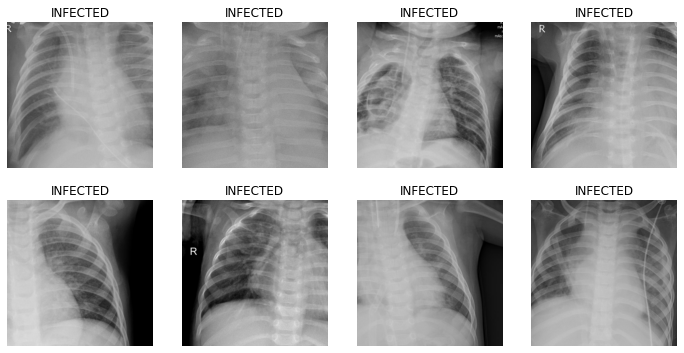

In [ ]:
dls.show_batch()

In [ ]:
lrnr = vision_learner(dls,resnet34,metrics=accuracy)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [ ]:
lrnr.fine_tune(3)

epoch,train_loss,valid_loss,accuracy,time
0,0.291848,0.739847,0.793269,05:11


epoch,train_loss,valid_loss,accuracy,time
0,0.194931,0.926140,0.754808,02:31
1,0.166062,0.718854,0.810897,02:30
2,0.036997,0.628316,0.818910,02:30


In [ ]:
net1 = lrnr.model[0]
net2 = lrnr.model[1]

In [ ]:
net2= torch.nn.Sequential(
    torch.nn.AdaptiveAvgPool2d(output_size=1), # (n,512,16,16) -> (n,512,1,1) 
    torch.nn.Flatten(), # (n,512,1,1) -> (n,512) 
    torch.nn.Linear(512,2,bias=False) 
)

In [ ]:
net = torch.nn.Sequential(
    net1,
    net2
)

lrnr2= Learner(dls,net,metrics=accuracy)

lrnr2.fine_tune(5)

epoch,train_loss,valid_loss,accuracy,time
0,0.276915,2.087037,0.626603,01:28


epoch,train_loss,valid_loss,accuracy,time
0,0.157743,0.639419,0.825321,01:27
1,0.120726,0.767331,0.804487,01:27
2,0.099292,0.732607,0.817308,01:26
3,0.032540,1.022304,0.801282,01:27
4,0.049157,0.900183,0.822115,01:27


In [ ]:
ximg = PILImage.create('/content/drive/MyDrive/data/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/TEST/INFECTED/person100_bacteria_475.jpeg')
x = first(dls.test_dl([ximg]))[0]

In [ ]:
sftmax=torch.nn.Softmax(dim=1)
sftmax(net(x)) 

TensorImage([[9.9987e-01, 1.3011e-04]], device='cuda:0',
            grad_fn=<AliasBackward0>)

In [ ]:
net2[2].weight

Parameter containing:
tensor([[ 0.0331, -0.0155,  0.0235,  ...,  0.0010,  0.0343,  0.0417],
        [ 0.0352,  0.0197,  0.0041,  ...,  0.0172,  0.0130, -0.0226]],
       requires_grad=True)

In [ ]:
why = torch.einsum('cb,abij->acij',
                   net2[2].weight.to('cuda:0'),#(512, 2)
                   net1(x) # (1, 512, 16, 16)
                   )# [1,2,1,1]

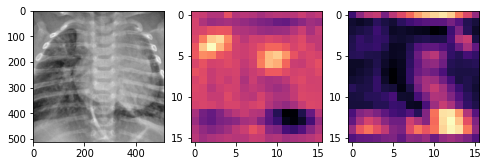

In [ ]:
fig, ax = plt.subplots(1,3,figsize=(8,4))
ax[0].imshow(torch.einsum('ocij -> ijc',dls.decode((x,))[0]).to("cpu"))
ax[1].imshow(why[0,0,:,:].to("cpu").detach(),cmap='magma')
ax[2].imshow(why[0,1,:,:].to("cpu").detach(),cmap='magma')

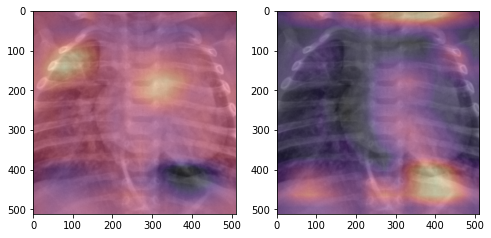

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(8,4))
ax[0].imshow(torch.einsum('ocij -> ijc',dls.decode((x,))[0]).to("cpu"))
ax[0].imshow(why[0,0,:,:].to("cpu").detach(),cmap='magma',extent=(0,511,511,0),interpolation='bilinear',alpha=0.5)
ax[1].imshow(torch.einsum('ocij -> ijc',dls.decode((x,))[0]).to("cpu"))
ax[1].imshow(why[0,1,:,:].to("cpu").detach(),cmap='magma',extent=(0,511,511,0),interpolation='bilinear',alpha=0.5)

### TYPE3)

## model 만들기

### ResNet50을 사용

https://deep-learning-study.tistory.com/475



In [ ]:
from torchvision import models
from torchvision.models.feature_extraction import get_graph_node_names
from torchvision.models.feature_extraction import create_feature_extractor

resnet = models.resnet50(pretrained=True)
print(resnet)

In [ ]:
import torch
num_classes = 2 # 이진분류이므로 2로 지정
num_ftrs = resnet.fc.in_features

resnet.fc = torch.nn.Linear(num_ftrs, num_classes)

resnet

In [ ]:
from torchsummary import summary
summary(resnet, input_size=(3, 224, 224), device=torch.device('cuda:0').type)

In [ ]:
import matplotlib.pyplot as plt

# visualize the filters of the first CNN layer
for w in resnet.parameters():
    w = w.data.cpu()
    print(w.shape)
    break

# normalize weights
min_w = torch.min(w)
w1 = (-1/(2 * 1)) * w + 0.5

# make grid to display it
grid_size = len(w1)
x_grid = [w1[i] for i in range(grid_size)]
x_grid = torchvision.utils.make_grid(x_grid, nrow=8, padding=1)

plt.figure(figsize=(10, 10))
plt.imshow(x_grid)